# Sentiment Analysis

In this notebook we will be doing some sentiment analysis in python using two different techniques:

- VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
- Roberta Pretrained Model from Huggingface 🤗

In [64]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')
import nltk
from tqdm import tqdm

In [ ]:
nltk.download('punkt_tab')

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

In [ ]:
nltk.download('maxent_ne_chunker_tab')

In [40]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/harpreetsingh/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [44]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/harpreetsingh/nltk_data...


True

## Getting Data 

In [4]:
df = pd.read_csv('./input/Reviews.csv')
df = df.head(500)
df.shape

(500, 10)

In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Exploratory Data Analysis

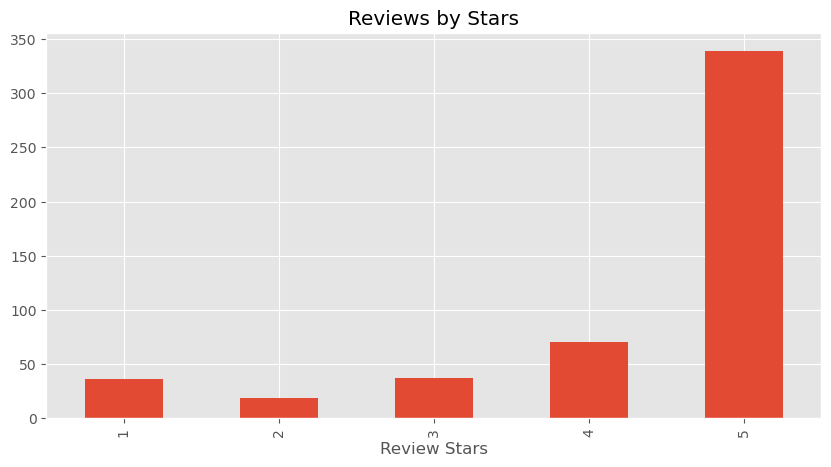

In [16]:
ax = df['Score'].value_counts().sort_index() \
     .plot(kind='bar', title='Reviews by Stars', figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [23]:
example = df['Text'][50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [31]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [35]:
# nktk.pos_tag Assigns grammatical tags to each word in a given text
# Identifies the part of speech for each word (noun, verb, adjective, etc.)
# Helps in understanding the grammatical structure of sentences
                                             
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [41]:
# `nltk.chunk.ne_chunk()` is used for Named Entity Recognition (NER), which
# - Identifies and classifies named entities in text
# - Transforms POS-tagged tokens into a tree structure
# - Identifies and classifies named entities in text


entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## VADER Sentiment

In [42]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm 

In [45]:
sia = SentimentIntensityAnalyzer()

In [47]:
sia.polarity_scores('This is a wonderful city')

{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'compound': 0.5719}

In [48]:
sia.polarity_scores('This is the worst food ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [49]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

### Run the polarity score on the entire dataset

In [67]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    rowId = row['Id']
    res[rowId] = sia.polarity_scores(text)





00%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1990.70it/s]

In [78]:
res[1]

{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}

In [79]:
vaders = pd.DataFrame(res).T 
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left')
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot vader Results

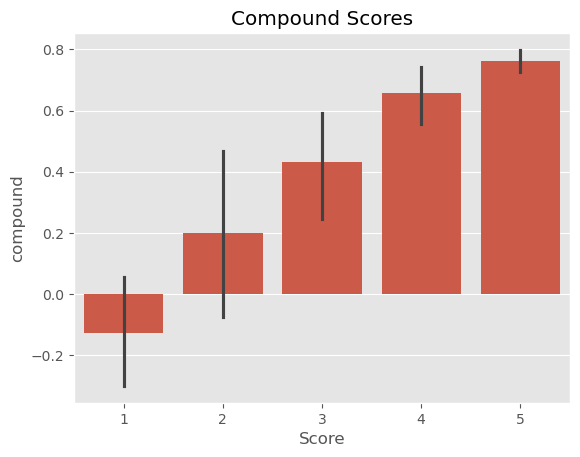

In [80]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Scores')
plt.show()

The above bar plot shows the distribution of compound scores for a dataset. Here are the key things it tells us:

- Scores range from around -0.2 to 0.8, indicating the data contains a mix of positive and negative sentiment.
- The highest frequency of scores is around 0.6-0.7, suggesting the overall sentiment is somewhat positive.
- There are some very high compound scores above 0.8, indicating the presence of strongly positive sentiments.
- There are also some negative scores around -0.1 to -0.2, showing the dataset contains some negatively classified samples as well.
- The scores are not normally distributed, but rather skewed towards the positive end of the scale, with a longer tail on the positive side compared to the negative side.

In summary, the bar plot provides a concise visual summary of the sentiment distribution in the dataset, highlighting the range, central tendency, and outliers in the compound sentiment scores. This information can be useful for understanding the overall sentiment expressed in the underlying textual data.

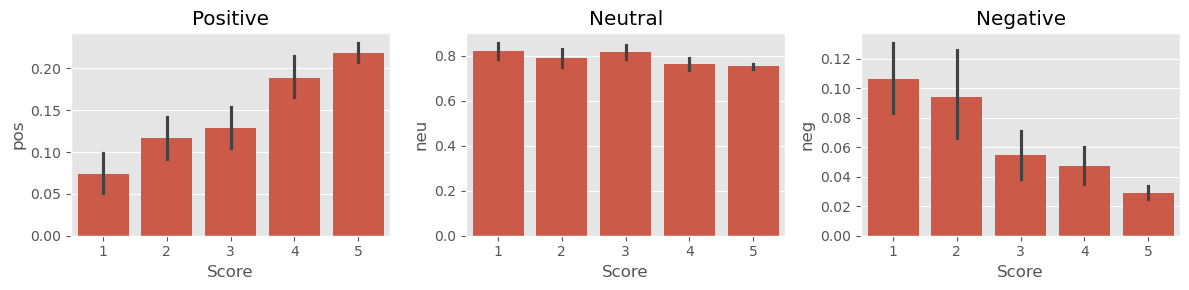

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

These three plots provide a comprehensive visualization of the sentiment distribution across positive, neutral, and negative scores. Here's what I can observe from them:
Positive Sentiment:

- The positive sentiment scores range from 0.05 to 0.20, with the highest frequency around 0.15-0.20.
- The distribution is right-skewed, indicating more high-positive scores than low-positive scores.
- The scores increase steadily from 1 to 5, suggesting a gradual rise in positive sentiment as the score increases.

Neutral Sentiment:

- The neutral sentiment scores range from 0.6 to 0.8, with the highest frequency around 0.7-0.75.
- The distribution is relatively symmetrical, with a peak around the middle of the range.
- The neutral scores remain fairly consistent across the different score levels, indicating a stable neutral sentiment.

Negative Sentiment:

- The negative sentiment scores range from 0.0 to 0.12, with the highest frequency around 0.04-0.08.
- The distribution is left-skewed, with more low-negative scores than high-negative scores.
- The negative scores decrease as the overall score increases, suggesting an inverse relationship between negative sentiment and the total score.

Overall, these plots provide a nuanced view of the sentiment distribution, highlighting the distinct patterns for positive, neutral, and negative sentiment. The positive sentiment shows a right-skewed distribution, the neutral sentiment is more symmetrical, and the negative sentiment is left-skewed. This information can be valuable for understanding the underlying sentiment dynamics in the data.